## Predict the category of crimes that occurred in the city by the bay

#### Computation Describtion:
This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## EDA
### Data exploration
Examining the dataset to understand its structure, size, and the types of variables it contains.

In [3]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


### Data Visualization
Creating visual representations of the data to help identify patterns, trends, and outliers.

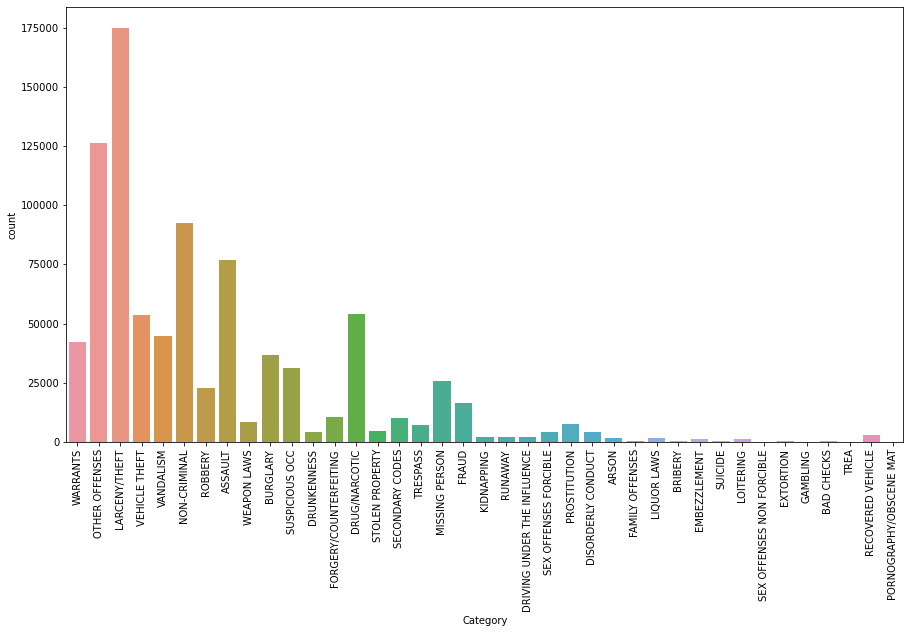

In [8]:
plt.figure(figsize=(15,8))
sns.countplot(x = df['Category'])
plt.xticks(rotation=90);
# Most of the arrasting are because of Larceny/Theft

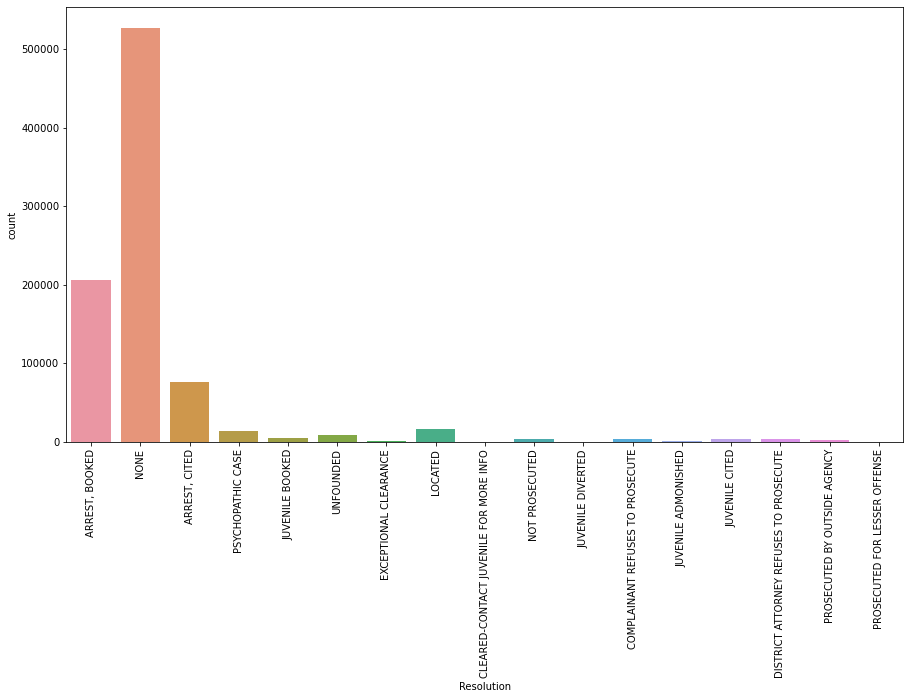

In [10]:
plt.figure(figsize=(15,8))
sns.countplot(x = df['Resolution'])
plt.xticks(rotation=90);

In [12]:
df['Dates'] = pd.to_datetime(df['Dates'])

df['year'] = df['Dates'].dt.year
df['month'] = df['Dates'].dt.month
df['day_of_month'] = df['Dates'].dt.day
df['day_of_week'] = df['Dates'].dt.day_of_week
df['hour'] = df['Dates'].dt.hour
df.drop(['Dates', 'DayOfWeek'], axis = 1, inplace = True)
df.dtypes

Category         object
Descript         object
PdDistrict       object
Resolution       object
Address          object
X               float64
Y               float64
year              int64
month             int64
day_of_month      int64
day_of_week       int64
hour              int64
dtype: object

In [13]:
df.columns = [item.lower() for item in df.columns]

In [14]:
pd.crosstab(df['day_of_week'], df['category'])

category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,228,10560,66,41,5262,608,263,7823,513,222,...,23,636,75,4447,1,1081,5946,7412,5811,1183
1,235,10280,76,37,5374,657,251,8474,461,156,...,23,714,66,4517,1,1114,5852,7263,6427,1176
2,200,10553,71,40,5457,660,221,9267,542,167,...,22,700,66,4851,0,1122,5927,7414,7029,1252
3,199,10246,66,39,5350,644,282,8454,496,165,...,15,679,89,4510,1,1047,5980,7456,6376,1282
4,220,11160,62,49,6327,541,352,7420,622,211,...,28,647,72,4924,1,1064,7092,8613,5926,1302
5,220,11995,45,42,4754,624,457,6390,833,137,...,21,581,73,4155,2,983,7326,8119,5364,1232
6,211,12082,20,41,4231,586,442,6143,813,108,...,16,583,67,4010,0,915,6602,7504,5281,1128


In [18]:
#first we are taking just the first 200 descriptions
top200 = df['descript'].value_counts().nlargest(200).index
df['descript'] = np.where(df['descript'].isin(top200), df['descript'], 'other')

In [21]:
top200.shape

(200,)

In [22]:
x = df.drop(['category','address'], axis = 1)
y = df['category']

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [32]:
#transform categorial variables to interger
le = LabelEncoder()
y = le.fit_transform(y)
x['descript'] = le.fit_transform(x['descript'])
x['pddistrict'] = le.fit_transform(x['pddistrict'])
x['resolution'] = le.fit_transform(x['resolution'])

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 1)

In [34]:
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

In [35]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [38]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

In [39]:
accuracy_score(y_pred, y_test)

0.46017705834117895

In [40]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [41]:
accuracy_score(y_pred, y_test)

0.9377410635648555

In [42]:
dtc = DecisionTreeClassifier(random_state= 1)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)

In [43]:
accuracy_score(y_pred, y_test)

0.9543915327846448

In [44]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

C:\ProgramData\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
accuracy_score(y_pred, y_test)

0.9593342849333374